In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from category_encoders import OneHotEncoder
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, ParameterGrid,  GridSearchCV, cross_val_score, cross_val_predict
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,  auc, roc_curve, auc, recall_score, precision_score, f1_score, precision_recall_fscore_support, precision_recall_curve
from sklearn.datasets import make_classification

import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.data.pandas_dataset import PandasDataset


mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")




In [3]:


# Load the data
df = pd.read_parquet('../data/data_clean6.parquet')

# Define the features and target
X = df.drop('Returned', axis=1)
y = df['Returned']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


# onehot encode
categorical_feature_onehot = ['day_of_week']
encoder_onehot = OneHotEncoder(cols=categorical_feature_onehot, handle_unknown='return_nan', handle_missing='return_nan')
X_train_encoded_hot = encoder_onehot.fit_transform(X_train, y_train)
X_test_encoded_hot = encoder_onehot.transform(X_test)

# Target encode
categorical_feature = ['Shop','CustomerID','ProductCode',  'BrandName',  'ModelGroup', 'ProductGroup', 'SaleDocumentNumber', 'Order_Date_FK']
encoder = TargetEncoder(cols=categorical_feature, handle_unknown='mean', handle_missing='mean')
X_train_encoded = encoder.fit_transform(X_train_encoded_hot, y_train)
X_test_encoded = encoder.transform(X_test_encoded_hot)

# Ensuring that no nan value are present in case some catagory data were not present in train data
target_mean = y_train.mean()
X_test_encoded = X_test_encoded.fillna(target_mean)  


# Normalize the data
sc = StandardScaler()
X_train_normalized = sc.fit_transform(X_train_encoded)  # fit on train and transform train 
X_test_normalized = sc.transform(X_test_encoded) # transform test with the same scaler based on train 

# Instantiate the model
xgb = XGBClassifier()

# Fit the model
param = {'gamma': 2, 'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 500, 'subsample': 0.85, 'scale_pos_weight':18} 




param = {'gamma': 2, 'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 500, 'subsample': 0.85, 'scale_pos_weight':18} 
xgb = XGBClassifier(**param)
xgb.fit(X_train_normalized, y_train)
y_pred = xgb.predict(X_test_normalized)


# # Perform cross-validation
# cross_val_scores = cross_val_score(xgb, X_train_encoded, y_train, cv=5)

# print(f"Cross-validation scores: {cross_val_scores}")
# print(f"Mean cross-validation score: {np.mean(cross_val_scores)}")


# Evaluate results
accuracy_train = xgb.score(X_train_normalized, y_train)
accuracy_test = xgb.score(X_test_normalized, y_test)
conf = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
support = precision_recall_fscore_support(y_test, y_pred)
curve = precision_recall_curve(y_test, y_pred)
classification = classification_report(y_test, y_pred)
print(accuracy_train, accuracy_test) 
print(conf)
print(classification_report(y_test, y_pred))
print(roc)


# Plot the confusion matrix
disp = plot_confusion_matrix(xgb, X_test_normalized, y_test
                             display_labels=df.target_names,
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title("Confusion Matrix")

plt.show()



# Create a confusion matrix using pandas crosstab
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Plot the confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.show()


0.9856240912955435 0.971643114058265
[[333102   5425]
 [  4556   8895]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    338527
           1       0.62      0.66      0.64     13451

    accuracy                           0.97    351978
   macro avg       0.80      0.82      0.81    351978
weighted avg       0.97      0.97      0.97    351978

0.8226319069174524


# AUC

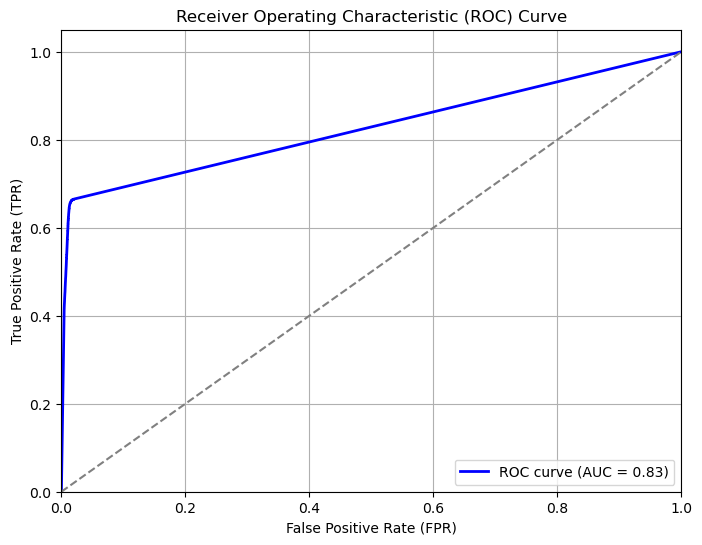

Number of unique predicted probabilities: 9036


In [4]:

y_pred_proba = xgb.predict_proba(X_test_normalized)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
unique_probabilities = np.unique(y_pred_proba[:, 1])
print(f"Number of unique predicted probabilities: {len(unique_probabilities)}")

# LIFT CURVE

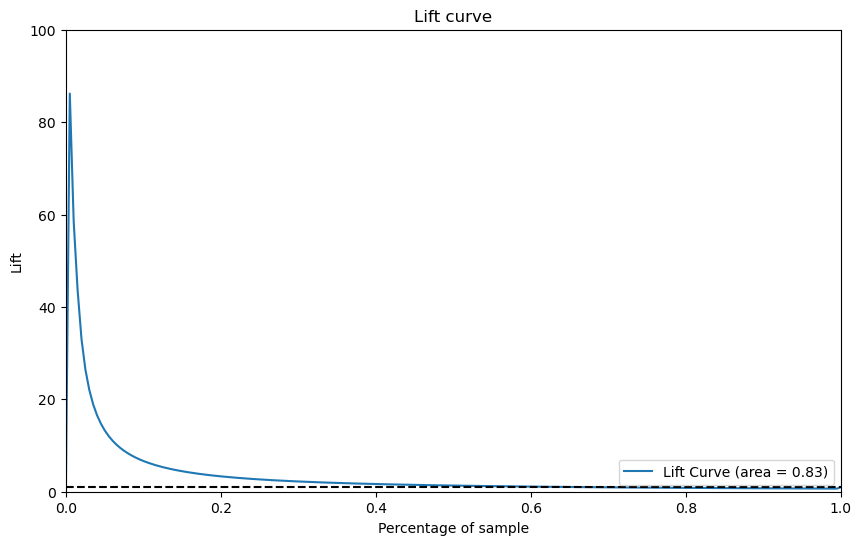

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_prob = xgb.predict_proba(X_test_normalized)[:, 1]

# Compute true positive rate and cumulative gain
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Compute lift curve
percentage = np.linspace(0, 1, 200)
lift = [tpr[fpr <= x][-1] / x if x > 0 else 1 for x in percentage]

# Plot Lift Curve
plt.figure(figsize=(10, 6))
plt.plot(percentage, lift, label='Lift Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [1, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 100])
plt.xlabel('Percentage of sample')
plt.ylabel('Lift')
plt.title('Lift curve')
plt.legend(loc="lower right")
plt.show()

# MLFLOW RECORDING CODE

In [ ]:

#--------------------------------------------------------------------------------------------------------------

#at the end of the code, launch the experiment : 
mlflow.set_experiment("Returns_predictions_XGB")

# mention the dataset used
dataset: PandasDataset = mlflow.data.from_pandas(df, source='../data/data_clean.parquet')


# Start an MLflow run
with mlflow.start_run():

     # Log the input data
     #mlflow.log_input(dataset, context="TRN")
     #mlflow.log_artifact("df.csv")

    # Log the hyperparameters from the model (they should in the variable in the code)
    mlflow.log_params(param)
    
     
     #log the rando and TT split
    mlflow.log_param("testsplit_size", 0.2)
    mlflow.log_param("random_state", 10)
     
     # Log the loss metric
    mlflow.log_metric("accuracy_test", accuracy_test)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_score", roc)
     #mlflow.log_metric("curve", curve)
     #mlflow.log_metric("conf_matrix", conf)
     #mlflow.log_metric("support", support)
     #mlflow.log_metric("classification", classification)
        

     # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Comments", "final 1hot")
       
#    # if prediction are not runed in the model (cause cluster for ex) run them here
#     predictions = ward.fit_predict(dfs)

     # Infer the model signature
    signature = infer_signature(X_test, y_pred)

     # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=XGBClassifier, #model to log
        artifact_path="XGB",  #local path for saving that model 
        signature=signature, #log the scheme of input&output - names, datatype, shape tec..
        input_example=df, #useful for model later use to check/exemplify the right data format
        registered_model_name="XGB" #name of the model in the mlflow UI
        )
